# Speech Recognition Project

# 1)- Importing key Modules

In [38]:
# I am an engineer. I care only about error not warning. So, let's be maverick and ignore warnings.
import warnings
warnings.filterwarnings('ignore')
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function

In [1]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt

# Getting data

In [2]:
DIR = '/Users/Hassan/Documents/Python work/Learning Projects/text2speech/'
fns = ['off/00b01445_nohash_0.wav',
       'go/00b01445_nohash_0.wav',
       'yes/00f0204f_nohash_0.wav']

### Getting to know data

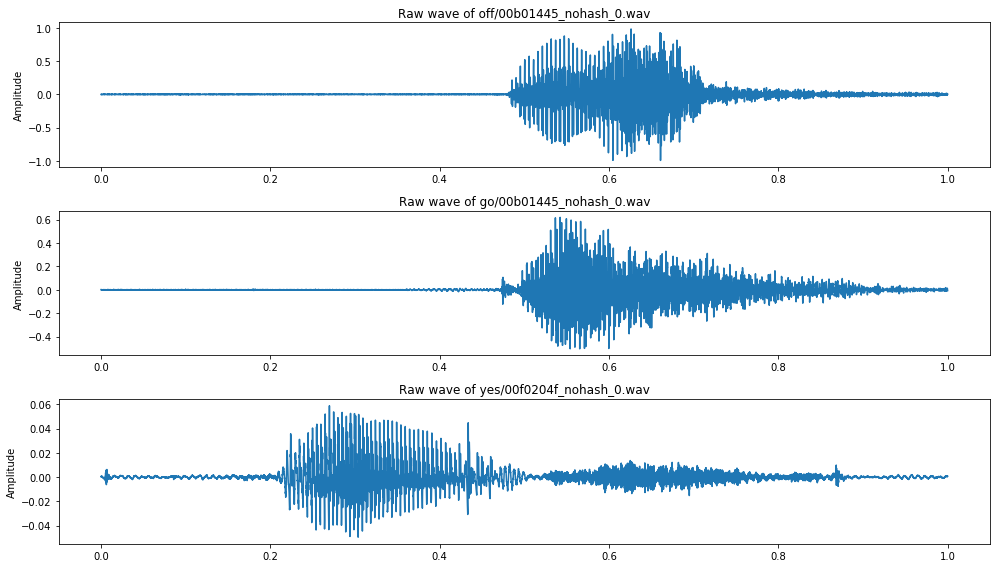

In [3]:
SAMPLE_RATE = 16000

def read_wav_file(x):
    # Read wavfile using scipy wavfile.read
    _, wav = wavfile.read(x) 
    # Normalize
    wav = wav.astype(np.float32) / np.iinfo(np.int16).max
        
    return wav

fig = plt.figure(figsize=(14, 8))
for i, fn in enumerate(fns):
    wav = read_wav_file(DIR + fn)

    ax = fig.add_subplot(3,1,i+1)
    ax.set_title('Raw wave of ' + fn)
    ax.set_ylabel('Amplitude')
    ax.plot(np.linspace(0, SAMPLE_RATE/len(wav), SAMPLE_RATE), wav)
fig.tight_layout()

# 3)-Embedding

Our sample variable i.e wav is just a vector with amplitudes in each time interval.We need to represent that pattern in a vector or matrix.Where, the procedure of representing a word in a vector or matrix form is called embedding.

### 3.1)- spectrograms

One dimensional vectors are easy to visualize, however, in speech recognition we rarely work with a raw amplitude data. The most common approaches are to convert audio files to spectrograms or MFCC (Mel-Frequency Cepstral Coefficients)

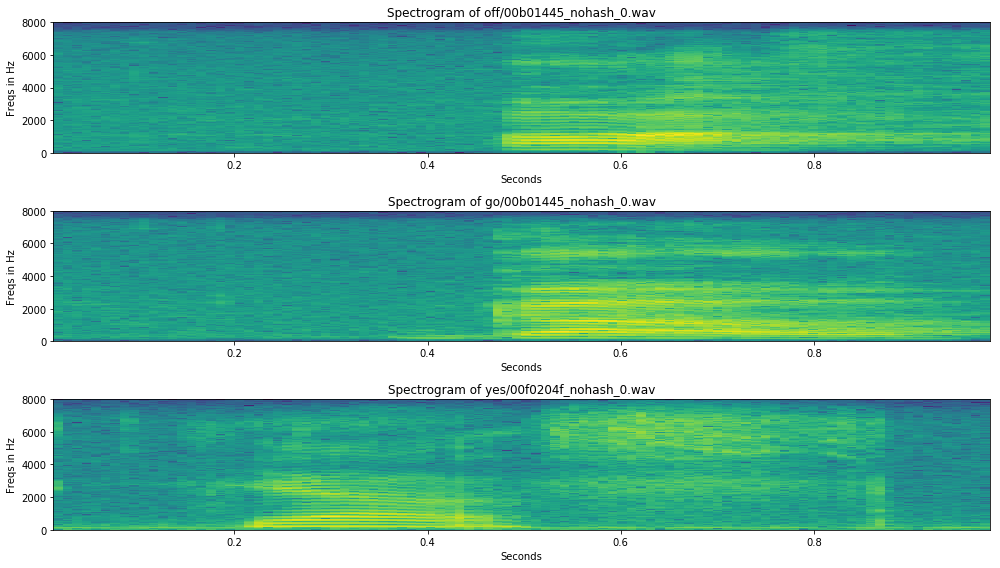

In [4]:
# import Short-time Fourier Transform (STFT).
#plot the log-spectrograms of three previously selected off, go and yes commands.
from scipy.signal import stft
 
def log_spectrogram(wav):
    freqs, times, spec = stft(wav, SAMPLE_RATE, nperseg = 400, noverlap = 240, nfft = 512, 
                              padded = False, boundary = None)
    # Log spectrogram
    amp = np.log(np.abs(spec)+1e-10)
    
    return freqs, times, amp
 
fig = plt.figure(figsize=(14, 8))
for i, fn in enumerate(fns):
    wav = read_wav_file(DIR + fn)
    freqs, times, amp = log_spectrogram(wav)
    
    ax = fig.add_subplot(3,1,i+1)
    ax.imshow(amp, aspect='auto', origin='lower', 
               extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax.set_title('Spectrogram of ' + fn)
    ax.set_ylabel('Freqs in Hz')
    ax.set_xlabel('Seconds')
fig.tight_layout()

According to **Nyquist theorem** if sample rate equals 16000, then frequencies are in the range [0, 8000]. The image size is 177 x 98 (time x number of frames). Here is an interesting fact to note. The frequency resolution of the spectrogram is around 8000 / 98 ≈  80 Hz, whereas the human ear works in the resolution of 3.6 Hz, way more precise than spectrogram. Nevertheless, for our purposes, the current frequency resolution will be sufficient.

# 4) Modeling

- Prepare data for selected words including train/test split
- Convert raw data to log-spectrograms
- Train machine learning model
- Check accuracy on test data

In [ ]:
"""


# Creating DataGenerator class for getting data as dataframe
import numpy as np
import keras

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(32,32,32), n_channels=1,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = np.load('data/' + ID + '.npy')

            # Store class
            y[i] = self.labels[ID]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)
        
"""

In [10]:
#We have converted data into log-spectrograms. So, now modeling steps. For this, we need to create dataframe
import numpy as np
from sklearn.metrics import accuracy_score
from keras.callbacks import EarlyStopping
from dataset import DatasetGenerator

 
DIR = '/Users/Hassan/Documents/Python work/Learning Projects/text2speech/' # unzipped train and test data
 
INPUT_SHAPE = (177,98,1)
BATCH = 32
EPOCHS = 15
 
LABELS = 'yes no up'.split()
NUM_CLASSES = len(LABELS)

- The  DIR  variable is a location of extracted audio files.
- The  INPUT_SHAPE  variable is a size of log-spectrogram. Please note that we extend it to 3D array so that it can be used in Convolutional Neural Networks.
- BATCH  and  EPOCHS  are used in training of neural networks.
- LABELS  is a list of selected words and  NUM_CLASSES  is just the number of labels that will be predicted.

In [11]:
dsGen =  DatasetGenerator(label_set=LABELS) 
# Load DataFrame with paths/labels
df = dsGen.load_data(DIR)

In [13]:
df.head(5) 

,label,label_id,user_id,wav_file
0,no,1,012c8314_nohash_0.wav,/Users/Hassan/Documents/Python work/Learning P...
1,no,1,0132a06d_nohash_0.wav,/Users/Hassan/Documents/Python work/Learning P...
2,no,1,0132a06d_nohash_1.wav,/Users/Hassan/Documents/Python work/Learning P...
3,no,1,0132a06d_nohash_2.wav,/Users/Hassan/Documents/Python work/Learning P...
4,no,1,0132a06d_nohash_3.wav,/Users/Hassan/Documents/Python work/Learning P...


In [25]:
df.to_csv('speech.csv', index= False)

In [19]:
df.shape

(7127, 4)

**Our output labels*

In [15]:
df.label.value_counts()

yes    2377
no     2375
up     2375
Name: label, dtype: int64

### 4.1)- Spliting into train-test & train-Validation data

In [16]:
dsGen.apply_train_test_split(test_size=0.3, random_state=2018)
dsGen.apply_train_val_split(val_size=0.2, random_state=2018)

### 4.2)- Build neural network

In [21]:
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Flatten
                          
def deep(features_shape, num_classes, act='relu'):
 
    # Input
    x = Input(name='inputs', shape=features_shape, dtype='float32')
    o = x
    
    # Flatten
    o = Flatten(name='flatten')(o)
    
    # Dense layer
    o = Dense(512, activation=act, name='dense1')(o)
    o = Dense(512, activation=act, name='dense2')(o)
    o = Dense(512, activation=act, name='dense3')(o)
    
    # Predictions
    o = Dense(num_classes, activation='softmax', name='pred')(o)
    
    # Print network summary
    Model(inputs=x, outputs=o).summary()
    
    return Model(inputs=x, outputs=o)

### 4.3)- Model compile

In [22]:
model_nn = deep(INPUT_SHAPE, NUM_CLASSES)
model_nn.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 177, 98, 1)        0         
_________________________________________________________________
flatten (Flatten)            (None, 17346)             0         
_________________________________________________________________
dense1 (Dense)               (None, 512)               8881664   
_________________________________________________________________
dense2 (Dense)               (None, 512)               262656    
_________________________________________________________________
dense3 (Dense)               (None, 512)               262656    
_________________________________________________________________
pred (Dense)                 (None, 3)                 1539      
Total params: 9,408,515
Trainable params: 9,408,515
Non-trainable params: 0
_________________________________________________________________


### 4.4)- Fit the model

In [23]:
callbacks = [EarlyStopping(monitor='val_acc', patience=4, verbose=1, mode='max')]

history = model_nn.fit_generator(generator=dsGen.generator(BATCH, mode='train'),
                              steps_per_epoch=int(np.ceil(len(dsGen.df_train)/BATCH)),
                              epochs=EPOCHS,
                              verbose=1,
                              callbacks=callbacks,
                              validation_data=dsGen.generator(BATCH, mode='val'),
                              validation_steps=int(np.ceil(len(dsGen.df_val)/BATCH)))

Epoch 1/15
125/125 [==============================] - 50s 398ms/step - loss: 10.5313 - acc: 0.3443 - val_loss: 10.9338 - val_acc: 0.3216
Epoch 2/15
125/125 [==============================] - 22s 174ms/step - loss: 10.5768 - acc: 0.3438 - val_loss: 10.9338 - val_acc: 0.3216
Epoch 3/15
125/125 [==============================] - 23s 181ms/step - loss: 10.5840 - acc: 0.3433 - val_loss: 10.9338 - val_acc: 0.3216
Epoch 4/15
125/125 [==============================] - 23s 181ms/step - loss: 10.5822 - acc: 0.3435 - val_loss: 10.9338 - val_acc: 0.3216
Epoch 5/15
125/125 [==============================] - 25s 197ms/step - loss: 10.5731 - acc: 0.3440 - val_loss: 10.9338 - val_acc: 0.3216
Epoch 00005: early stopping


# Convolutional Neural Networks

Looking at trends of accuracy and validation accuracy, we might end up getting a plot where our model does not learn. Hence, we move to another algorithm i.e CNN model

In [27]:
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization 

def deep_cnn(features_shape, num_classes, act='relu'):

    x = Input(name='inputs', shape=features_shape, dtype='float32')
    o = x
    
    # Block 1
    o = Conv2D(32, (3, 3), activation=act, padding='same', strides=1, name='block1_conv', input_shape=features_shape)(o)
    o = MaxPooling2D((3, 3), strides=(2,2), padding='same', name='block1_pool')(o)
    o = BatchNormalization(name='block1_norm')(o)
    
    # Block 2
    o = Conv2D(32, (3, 3), activation=act, padding='same', strides=1, name='block2_conv')(o)
    o = MaxPooling2D((3, 3), strides=(2,2), padding='same', name='block2_pool')(o)
    o = BatchNormalization(name='block2_norm')(o)

    # Block 3
    o = Conv2D(32, (3, 3), activation=act, padding='same', strides=1, name='block3_conv')(o)
    o = MaxPooling2D((3, 3), strides=(2,2), padding='same', name='block3_pool')(o)
    o = BatchNormalization(name='block3_norm')(o)

    # Flatten
    o = Flatten(name='flatten')(o)
    
    # Dense layer
    o = Dense(64, activation=act, name='dense')(o)
    o = BatchNormalization(name='dense_norm')(o)
    o = Dropout(0.2, name='dropout')(o)
    
    # Predictions
    o = Dense(num_classes, activation='softmax', name='pred')(o)

    # Print network summary
    Model(inputs=x, outputs=o).summary()
    
    return Model(inputs=x, outputs=o)

### compile & fit model

In [28]:
model = deep_cnn(INPUT_SHAPE, NUM_CLASSES)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc'])
 
callbacks = [EarlyStopping(monitor='val_acc', patience=4, verbose=1, mode='max')]
 
history = model.fit_generator(generator=dsGen.generator(BATCH, mode='train'),
                              steps_per_epoch=int(np.ceil(len(dsGen.df_train)/BATCH)),
                              epochs=EPOCHS,
                              verbose=1,
                              callbacks=callbacks,
                              validation_data=dsGen.generator(BATCH, mode='val'),
                              validation_steps=int(np.ceil(len(dsGen.df_val)/BATCH)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 177, 98, 1)        0         
_________________________________________________________________
block1_conv (Conv2D)         (None, 177, 98, 32)       320       
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 89, 49, 32)        0         
_________________________________________________________________
block1_norm (BatchNormalizat (None, 89, 49, 32)        128       
_________________________________________________________________
block2_conv (Conv2D)         (None, 89, 49, 32)        9248      
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 45, 25, 32)        0         
_________________________________________________________________
block2_norm (BatchNormalizat (None, 45, 25, 32)        128       
__________

### Evaluation

In [29]:
#To check whether our model generalizes well for unseen samples, let’s calculate the accuracy on the test data.
y_pred_proba = model.predict_generator(dsGen.generator(BATCH, mode='test'), 
                                     int(np.ceil(len(dsGen.df_test)/BATCH)), 
                                     verbose=1)

67/67 [==============================] - 44s 650ms/step


In [30]:
print(y_pred_proba[:5])

[[5.3436557e-05 9.9981755e-01 1.2909868e-04]
 [1.3051814e-04 9.9986935e-01 8.7752127e-08]
 [3.5233997e-02 3.7896642e-01 5.8579957e-01]
 [8.0149010e-04 9.4239771e-02 9.0495872e-01]
 [9.9449968e-01 5.1925946e-03 3.0762903e-04]]


These are prediction values for class 0,1 and 2 i.e no, yes, off

In [31]:
y_pred = np.argmax(y_pred_proba, axis=1)

y_true = dsGen.df_test['label_id'].values

**Accuracy**

In [32]:
acc_score = accuracy_score(y_true, y_pred)
print(acc_score)

0.9121084618980833


**Other metrics of performance evaluation**

In [34]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       719
           1       0.84      0.97      0.90       738
           2       0.99      0.81      0.89       682

   micro avg       0.91      0.91      0.91      2139
   macro avg       0.92      0.91      0.91      2139
weighted avg       0.92      0.91      0.91      2139



Results are consistent for all three classes

In [35]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
cm

array([[686,  32,   1],
       [ 21, 715,   2],
       [ 28, 104, 550]], dtype=int64)

In [36]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

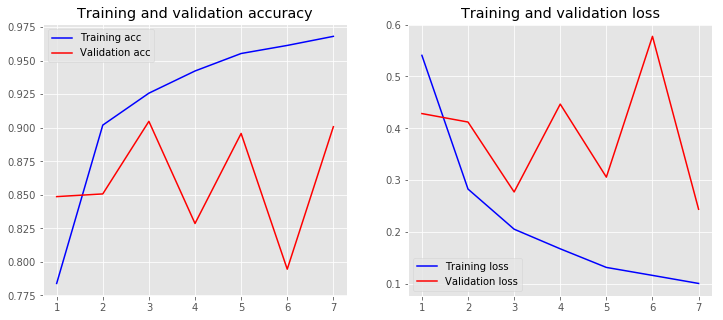

In [37]:
plot_history(history)